<b> A complete guide: https://scikit-learn.org/stable/modules/clustering.html </b>

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

In [59]:
#scaling, normalization
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
#kmeans, dbscan, hierarchical (sklearn)
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
#evaluation
from sklearn.metrics import silhouette_score

#distance matrix (dbscan elbow, hierarchical)
from scipy.spatial.distance import pdist, squareform
# hierarchical (scipy)
from scipy.cluster.hierarchy import linkage, dendrogram

In [60]:
df = pd.read_csv("seismic-bumps.csv")

In [61]:
df.head()

,seismic,seismoacoustic,shift,genergy,gpuls,gdenergy,gdpuls,hazard,nbumps,nbumps2,nbumps3,nbumps4,nbumps5,nbumps6,nbumps7,nbumps89,energy,maxenergy,class
0,a,a,N,15180,48,-72,-72,a,0,0,0,0,0,0,0,0,0,0,0
1,a,a,N,14720,33,-70,-79,a,1,0,1,0,0,0,0,0,2000,2000,0
2,a,a,N,8050,30,-81,-78,a,0,0,0,0,0,0,0,0,0,0,0
3,a,a,N,28820,171,-23,40,a,1,0,1,0,0,0,0,0,3000,3000,0
4,a,a,N,12640,57,-63,-52,a,0,0,0,0,0,0,0,0,0,0,0


In [62]:
# Applying log transform

df['log_genergy'] = np.log(df['genergy'])
df['log_gpuls'] = np.log(df['gpuls'])
df['log_maxenergy'] = np.log(0.01+df['maxenergy'])

In [37]:
# dropping the row containing the outlier
#df.drop(index=[812], inplace=True)
#df.drop(index=[816], inplace=True)

In [63]:
cols = df.select_dtypes([np.number]).columns
cols = np.delete(cols, np.where(cols == 'class'))
cols = ['log_gpuls', 'log_genergy',"log_maxenergy"]
#gdenergy',

num_values = df[cols].values

scaler = RobustScaler()
values_scal = scaler.fit_transform(num_values)

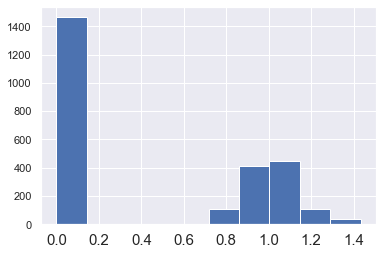

In [312]:
plt.hist(values_scal[:,2], edgecolor='white')

plt.xticks(fontsize=15)
plt.show()

In [ ]:
plt.hist(num_values[:,2], edgecolor='white')

plt.xticks(fontsize=15)
plt.show()

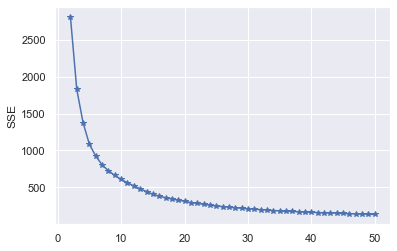

In [314]:
# calculating the Sum of Squared Error (SSE) for K in range(2, 52)

sse_list = []

for k in range(2, 51):
    kmeans = KMeans(n_clusters=k, n_init=10, max_iter=100)
    kmeans.fit(values_scal)
    sse_list.append( kmeans.inertia_ )
    
plt.plot(range(2, len(sse_list)+2), sse_list, marker='*')
plt.ylabel('SSE')
plt.show()

In [315]:
# Applying k-means on numerical attributes of the dataset

kmeans = KMeans( n_clusters=5, n_init=20, max_iter=100 )
kmeans.fit(values_scal)
print('SSE', kmeans.inertia_)
print('Silhouette', silhouette_score(values_scal, kmeans.labels_))

SSE 1081.1960045087792
Silhouette 0.3890331907737698


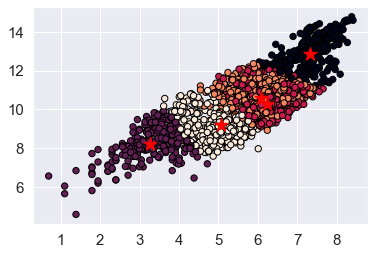

In [316]:
# Plotting the clusters whith their centroids for the attributes 'genergy' and 'gpuls'

plt.scatter( num_values[:,0], num_values[:,1], s=40, edgecolor='black', c= kmeans.labels_ )

centers = kmeans.cluster_centers_
centers = scaler.inverse_transform(centers)
plt.scatter( centers[:,0], centers[:,1], c='red', marker='*', s=200 )

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.show()

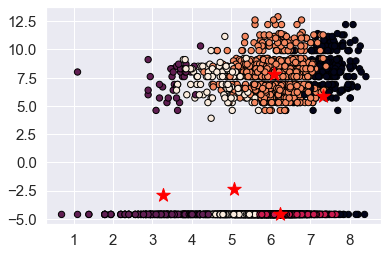

In [317]:
# Plotting the clusters whith their centroids for the attributes 'gdenergy' and 'gdpuls'

plt.scatter( num_values[:,0], num_values[:,2], s=40, edgecolor='black', c= kmeans.labels_ )

centers = kmeans.cluster_centers_
centers = scaler.inverse_transform(centers)
plt.scatter( centers[:,0], centers[:,2], c='red', marker='*', s=200 )

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.show()

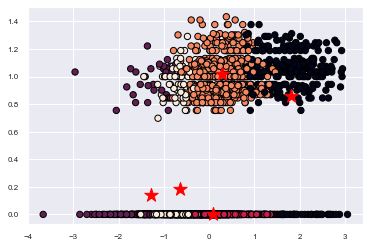

In [318]:
# Plotting the clusters whith their centroids for the attributes 'energy' and 'maxenergy'

plt.scatter( values_scal[:,1], values_scal[:,2], s=40, edgecolor='black', c= kmeans.labels_ )

centers = kmeans.cluster_centers_
plt.scatter( centers[:,1], centers[:,2], c='red', marker='*', s=200 )

plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

plt.show()

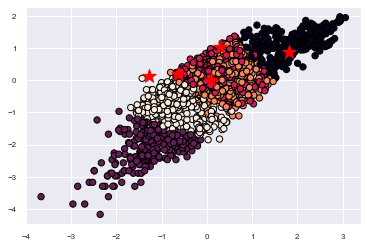

In [319]:
# Plotting the clusters whith their centroids for the attributes 'energy' and 'maxenergy'

plt.scatter( values_scal[:,1], values_scal[:,0], s=40, edgecolor='black', c= kmeans.labels_ )

centers = kmeans.cluster_centers_
plt.scatter( centers[:,1], centers[:,2], c='red', marker='*', s=200 )

plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

plt.show()

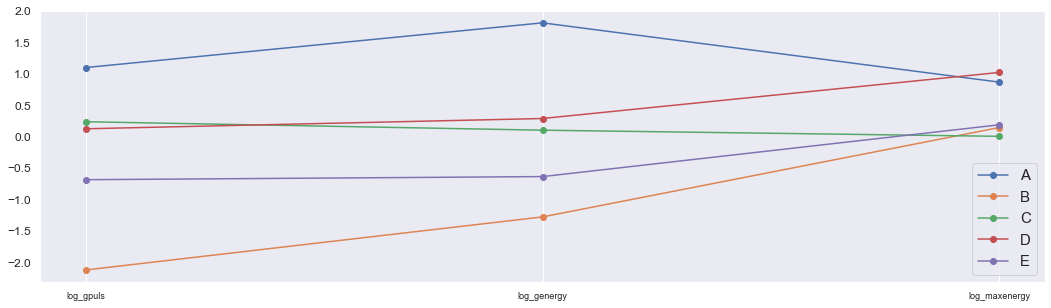

In [320]:
plt.figure(figsize=(18, 5))

clust_name = ['A', 'B', 'C', 'D', 'E']
for i in range(len(centers)):
    plt.plot(centers[i], marker='o', label=clust_name[i])
    
plt.xticks(range(0,len(cols)), cols, fontsize=9)
plt.yticks(fontsize=12)

plt.legend(fontsize=15, loc='best')
plt.grid(axis='y')

[]

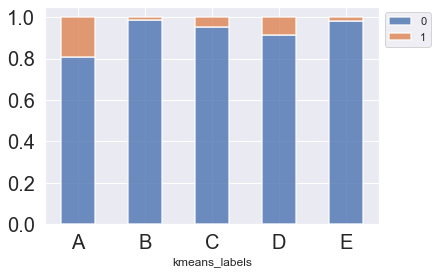

In [321]:
df['kmeans_labels'] = kmeans.labels_

bar_pl = df['class'].groupby(df['kmeans_labels']).value_counts(normalize=True).unstack(1)
bar_pl.plot(kind='bar', stacked=True, alpha=0.8, edgecolor='white', linewidth=1.5)

plt.xticks(range(0, len(clust_name)), clust_name, fontsize=20, rotation=0)
plt.yticks(fontsize=20)
plt.legend(bbox_to_anchor=(1,1))

plt.plot()

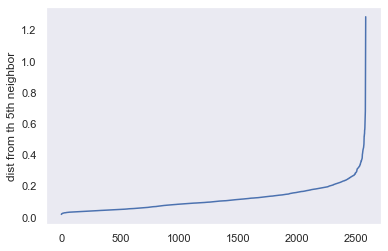

In [322]:
# Determing eps and minPts with the elbow method (see slide Clustering: Density-based-methods page 20 for info)

dist = pdist(values_scal, 'euclidean')
dist = squareform(dist)

k=5
kth_distances = []
for d in dist:
    index_kth_distance = np.argsort(d)[k]
    kth_distances.append(d[index_kth_distance])
    
plt.plot(range(0, len(kth_distances)), sorted(kth_distances))
plt.ylabel('dist from th 5th neighbor')

plt.grid(alpha=0.5)
plt.show()

In [323]:
# Applying DBSCAN on on numerical attributes of the dataset with eps = 80 and min_sample = 5

dbscan = DBSCAN( eps=0.5, min_samples=5)
dbscan.fit(values_scal)

DBSCAN()

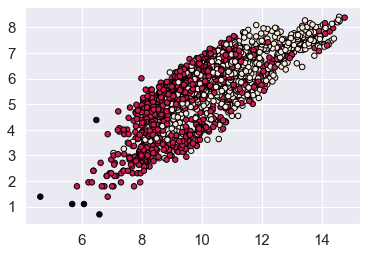

In [324]:
# Plotting the clusters for the attributes 'genergy' and 'gpuls'

plt.scatter( num_values[:,1], num_values[:,0], s=30,edgecolor='black', c= dbscan.labels_ )

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.show()

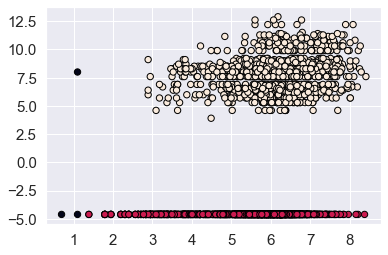

In [325]:
# Plotting the clusters for the attributes 'log_genergy' and 'log_gpuls'

plt.scatter( num_values[:,0], num_values[:,2], s=40, edgecolor='black', c= dbscan.labels_ )

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.show()

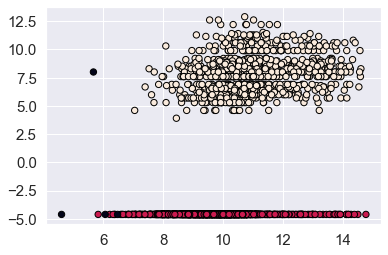

In [326]:
# Plotting the clusters for the attributes 'gdenergy' and 'gdpuls'

plt.scatter( num_values[:,1], num_values[:,2], s=40, edgecolor='black', c= dbscan.labels_ )

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.show()

[]

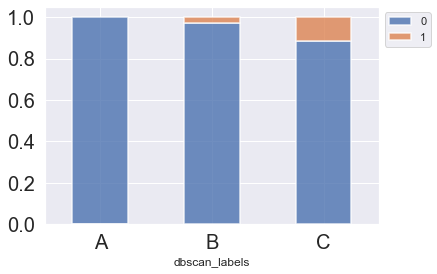

In [333]:
df['dbscan_labels'] = dbscan.labels_
clust_name = ['A', 'B', 'C']
bar_pl = df['class'].groupby(df['dbscan_labels']).value_counts(normalize=True).unstack(1)
bar_pl.plot(kind='bar', stacked=True, alpha=0.8, edgecolor='white', linewidth=1.5)

plt.xticks(range(0, len(clust_name)), clust_name, fontsize=20, rotation=0)
plt.yticks(fontsize=20)
plt.legend(bbox_to_anchor=(1,1))

plt.plot()

In [331]:
print('Silhouette', silhouette_score(values_scal, dbscan.labels_))

Silhouette 0.26083063718649013


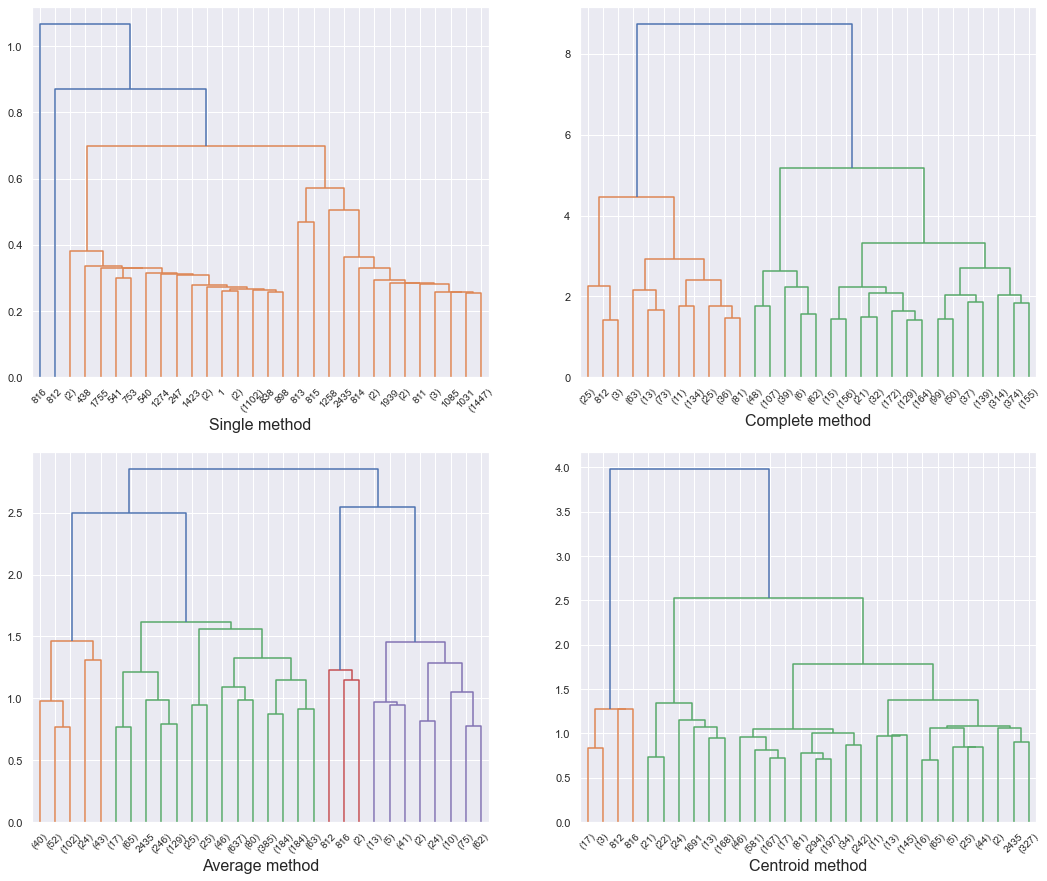

In [64]:
# Plotting dendrograms using different inter-cluster distance methods

data_dist = pdist(values_scal, metric='euclidean')

fig, axes = plt.subplots(2, 2, figsize=(18, 15))

data_link = linkage(data_dist, method='single')
dn1 = dendrogram(data_link, ax=axes[0,0], truncate_mode='lastp')
axes[0,0].set_xlabel("Single method",fontsize=16)

data_link = linkage(data_dist, method='complete')
dn2 = dendrogram(data_link, ax=axes[0,1], truncate_mode='lastp')
axes[0,1].set_xlabel("Complete method",fontsize=16)

data_link = linkage(data_dist, method='average')
dn3 = dendrogram(data_link, ax=axes[1,0], truncate_mode='lastp')
axes[1,0].set_xlabel("Average method",fontsize=16)

data_link = linkage(data_dist, method='centroid')
dn4 = dendrogram(data_link, ax=axes[1,1], truncate_mode='lastp')
axes[1,1].set_xlabel("Centroid method",fontsize=16)

plt.show()

In [121]:
hier = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='average')
hier.fit(values_scal)

AgglomerativeClustering(linkage='average', n_clusters=4)

[]

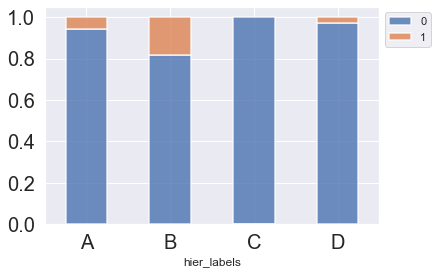

In [122]:
df['hier_labels'] = hier.labels_
clust_name = ['A', 'B', 'C', 'D']
bar_pl = df['class'].groupby(df['hier_labels']).value_counts(normalize=True).unstack(1)
bar_pl.plot(kind='bar', stacked=True, alpha=0.8, edgecolor='white', linewidth=1.5)

plt.xticks(range(0, len(clust_name)), clust_name, fontsize=20, rotation=0)
plt.yticks(fontsize=20)
plt.legend(bbox_to_anchor=(1,1))

plt.plot()

In [123]:
print('Silhouette', silhouette_score(values_scal, hier.labels_))

Silhouette 0.3730550256298249
